In [57]:
import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [44]:
np.random.seed(42)

In [45]:
data = pd.read_csv("../data/used-cars/audi.csv")

data = data.rename(
    {
        "model": "model",
        "year": "year",
        "price": "price",
        "transmission": "transmission",
        "mileage": "mileage",
        "model": "model",
        "fuelType": "fuel_type",
        "tax": "tax",
        "mpg": "mpg",
        "engineSize": "engine_size",
    },
    axis=1,
)

data = data.reindex(sorted(data.columns), axis=1)

print("--------------------------------------------------")
print("Sample")
print("--------------------------------------------------")

data.sample(10)

--------------------------------------------------
Sample
--------------------------------------------------


,engine_size,fuel_type,mileage,model,mpg,price,tax,transmission,year
10442,2.0,Diesel,49500,A4,62.8,9990,30,Manual,2012
2907,1.6,Diesel,4352,A3,51.4,22382,145,Manual,2019
7388,2.0,Diesel,7000,A6,47.9,28990,150,Semi-Auto,2019
3016,1.5,Petrol,3925,A3,44.1,30777,145,Semi-Auto,2020
7890,1.4,Petrol,22000,A4,51.4,14950,145,Manual,2016
483,1.6,Diesel,3578,Q2,47.9,24365,145,Manual,2019
5799,3.0,Diesel,22639,Q7,48.7,30495,165,Semi-Auto,2016
6026,3.0,Diesel,14468,A7,52.3,29900,145,Semi-Auto,2017
1084,2.0,Diesel,25214,A4,74.3,15256,0,Manual,2016
7873,1.6,Diesel,789,Q2,47.9,24950,145,Semi-Auto,2020


In [46]:
print("--------------------------------------------------")
print("Data Types")
print("--------------------------------------------------")

for label, content in data.items():
    print(f"{label}: {content.dtypes}")

--------------------------------------------------
Data Types
--------------------------------------------------
engine_size: float64
fuel_type: object
mileage: int64
model: object
mpg: float64
price: int64
tax: int64
transmission: object
year: int64


In [47]:
print("--------------------------------------------------")
print("Missing Values")
print("--------------------------------------------------")

for label, content in data.items():
    print(f"{label}: {content.isna().sum()}")

--------------------------------------------------
Missing Values
--------------------------------------------------
engine_size: 0
fuel_type: 0
mileage: 0
model: 0
mpg: 0
price: 0
tax: 0
transmission: 0
year: 0


In [48]:
print("--------------------------------------------------")
print("Unique Values")
print("--------------------------------------------------")

for label, content in data.items():
    print(f"{label}: {len(content.unique())}")

--------------------------------------------------
Unique Values
--------------------------------------------------
engine_size: 19
fuel_type: 3
mileage: 7725
model: 26
mpg: 104
price: 3260
tax: 37
transmission: 3
year: 21


In [49]:
print("--------------------------------------------------")
print("Descriptive Statistics")
print("--------------------------------------------------")

data.describe().round(3)

--------------------------------------------------
Descriptive Statistics
--------------------------------------------------


,engine_size,mileage,mpg,price,tax,year
count,10668.000,10668.000,10668.00,10668.000,10668.000,10668.000
mean,1.931,24827.244,50.77,22896.685,126.011,2017.101
std,0.603,23505.257,12.95,11714.842,67.170,2.167
min,0.000,1.000,18.90,1490.000,0.000,1997.000
25%,1.500,5968.750,40.90,15130.750,125.000,2016.000
50%,2.000,19000.000,49.60,20200.000,145.000,2017.000
75%,2.000,36464.500,58.90,27990.000,145.000,2019.000
max,6.300,323000.000,188.30,145000.000,580.000,2020.000


--------------------------------------------------
Pairwise Relationships
--------------------------------------------------


c:\Users\danie\_data\courses\tensorflow\env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


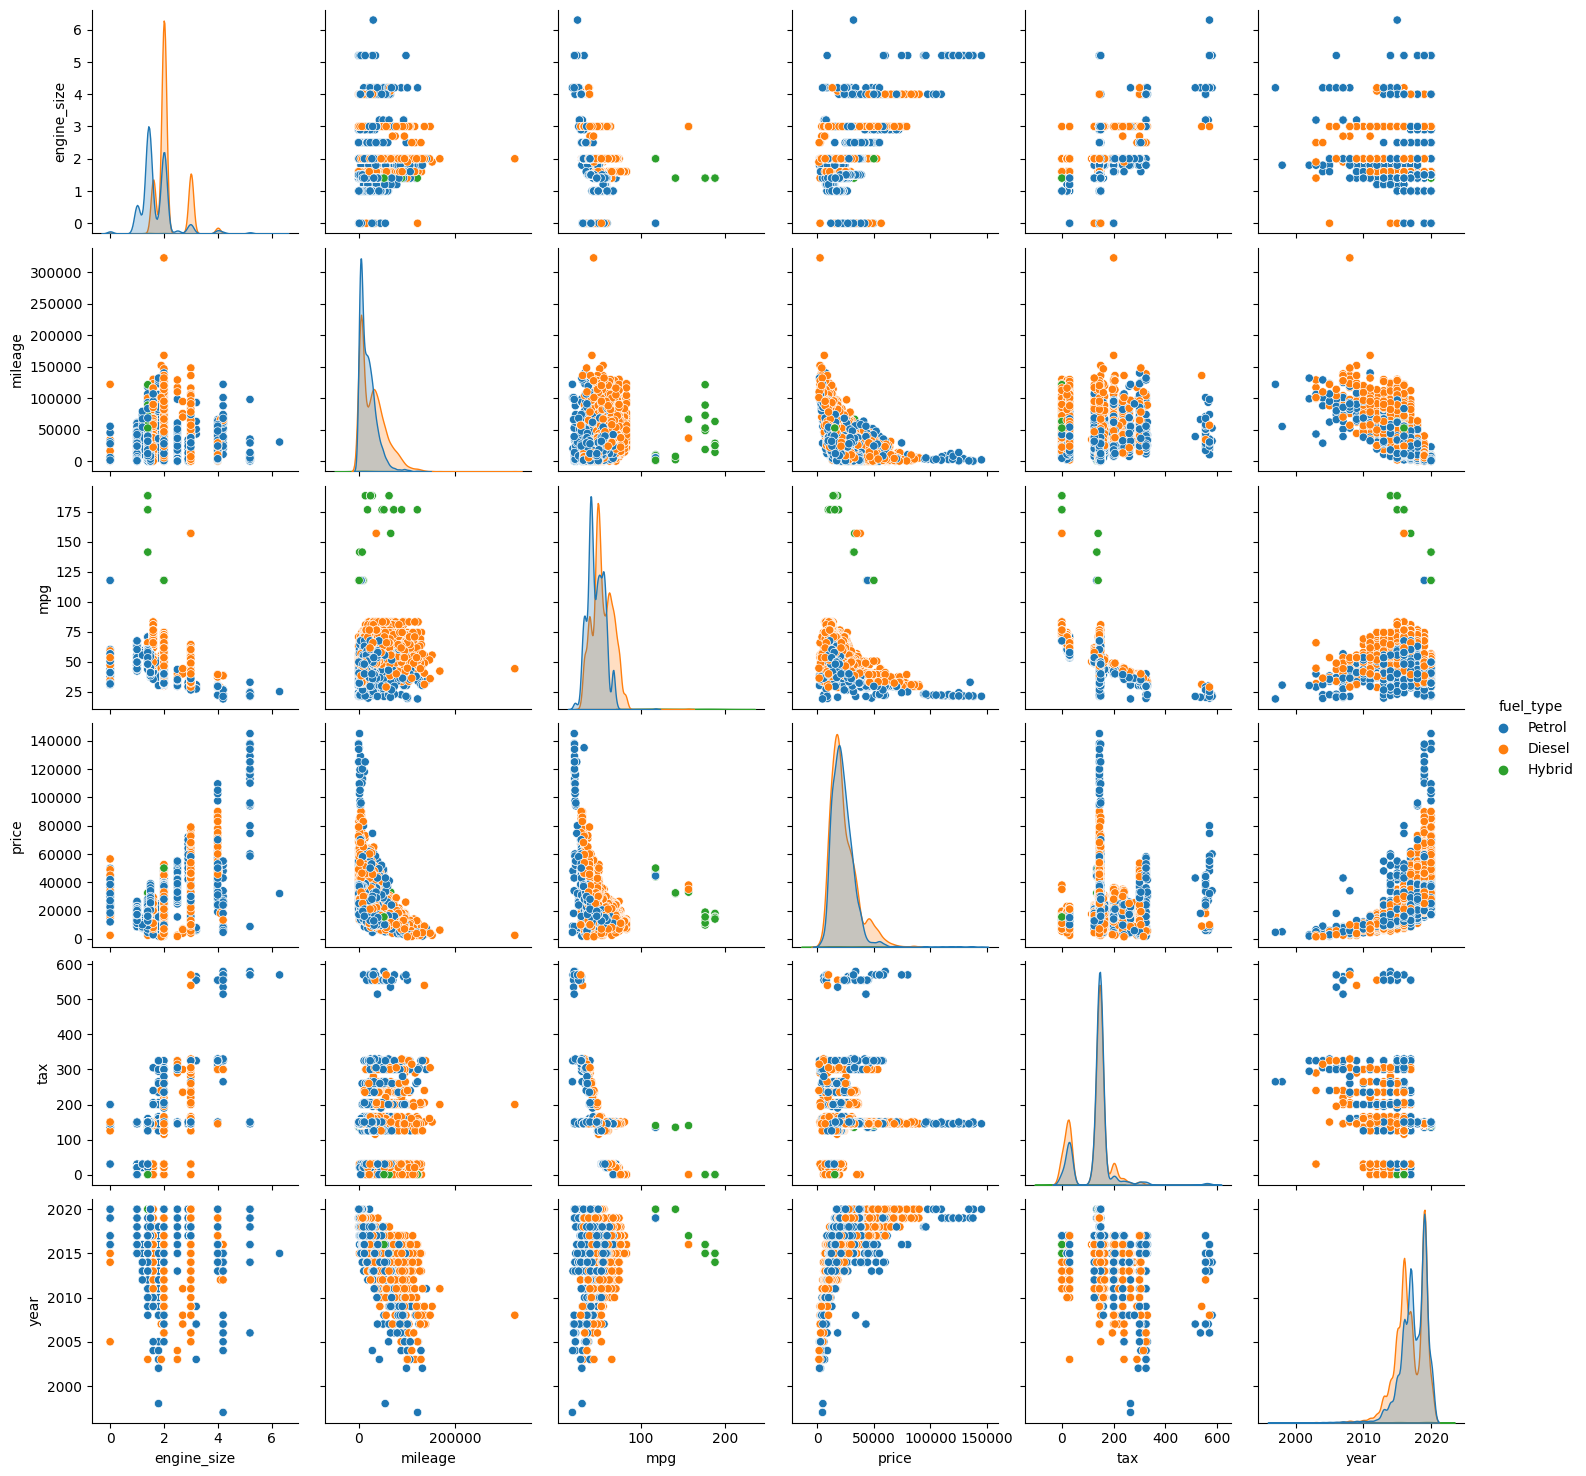

In [50]:
print("--------------------------------------------------")
print("Pairwise Relationships")
print("--------------------------------------------------")

sns.pairplot(data, hue="fuel_type")

In [51]:
X = data.drop(["price"], axis=1)
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
cat_features = ["fuel_type", "model", "transmission"]
num_features = ["engine_size", "mileage", "mpg", "tax", "year"]

In [53]:
imputer = ColumnTransformer(
    [
        (
            "imputer_cat",
            SimpleImputer(strategy="most_frequent", add_indicator=True),
            cat_features,
        ),
        (
            "imputer_num",
            SimpleImputer(strategy="median", add_indicator=True),
            num_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

scaler = ColumnTransformer(
    [
        (
            "scaler_num",
            MinMaxScaler(feature_range=(0, 1)),
            num_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

encoder = ColumnTransformer(
    [
        (
            "encoder_cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

estimator = RandomForestRegressor()

In [54]:
pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),
        ("encoder", encoder),
        ("estimator", estimator),
    ],
).set_output(transform="pandas")

pipeline.fit(X_train, y_train)

pipeline_score_test = pipeline.score(X_test, y_test)
pipeline_score_train = pipeline.score(X_train, y_train)

print("------------------------------------------------------------")
print("Base Model")
print("------------------------------------------------------------")
print(f"Test Score: {pipeline_score_test.round(4)}")
print(f"Train Score: {pipeline_score_train.round(4)}")

------------------------------------------------------------
Base Model
------------------------------------------------------------
Test Score: 0.9656
Train Score: 0.9933


In [55]:
model = GridSearchCV(
    pipeline,
    {
        "estimator__max_features": [0.25, 0.5, 1],
        "estimator__min_samples_leaf": [1, 2, 4],
        "estimator__n_estimators": [50, 100, 200],
    },
    cv=5,
    verbose=2,
)

model.fit(X_train, y_train)

model_params = model.best_params_

model_score_test = model.score(X_test, y_test)
model_score_train = model.score(X_train, y_train)

print("------------------------------------------------------------")
print(f"Model Parameters: {model_params}")
print(f"Test Score: {model_score_test.round(4)}")
print(f"Train Score: {model_score_train.round(4)}")
print("------------------------------------------------------------")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.9s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.9s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.9s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.8s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.9s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=100; total time=   1.8s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=100; total time=   1.8s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=100; total time=   1.8s

In [58]:
best_estimator = RandomForestRegressor(
    max_features=model_params["estimator__max_features"],
    min_samples_leaf=model_params["estimator__min_samples_leaf"],
    n_estimators=model_params["estimator__n_estimators"],
)

best_model = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("scaler", scaler),
        ("estimator", best_estimator),
    ],
)

scores = {
    "mae": abs(
        cross_val_score(
            best_model,
            X,
            y,
            cv=5,
            scoring="neg_mean_absolute_error",
        ).mean()
    ),
    "mse": abs(
        cross_val_score(
            best_model,
            X,
            y,
            cv=5,
            scoring="neg_mean_squared_error",
        ).mean()
    ),
    "msle": abs(
        cross_val_score(
            best_model,
            X,
            y,
            cv=5,
            scoring="neg_mean_squared_log_error",
        ).mean()
    ),
    "r2": abs(
        cross_val_score(
            best_model,
            X,
            y,
            cv=5,
            scoring="r2",
        ).mean()
    ),
    "mape": abs(
        cross_val_score(
            best_model,
            X,
            y,
            cv=5,
            scoring="neg_mean_absolute_percentage_error",
        ).mean()
    ),
}

print("------------------------------------------------------------")
print("Cross-validated Model")
print("------------------------------------------------------------")
print(f"Mean Absolute Error: {scores['mae'].round(4)}")
print(f"Mean Squared Error: {scores['mse'].round(4)}")
print(f"Mean Squared Log Error: {scores['msle'].round(4)}")
print(f"R Squared: {scores['r2'].round(4)}")
print(f"Mean Absolute Percentage Error: {scores['mape'].round(4)}")

------------------------------------------------------------
Cross-validated Model
------------------------------------------------------------
Mean Absolute Error: 1581.4245
Mean Squared Error: 6098121.9893
Mean Squared Log Error: 0.0129
R Squared: 0.952
Mean Absolute Percentage Error: 0.0785
